[Chapter 7] Portfolio Construction

100
0.6793919470797761
0.00495905524173486 0.0013322973790120618
0.003455970753593775 0.0015087460763945101


<string>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
<string>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
<string>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


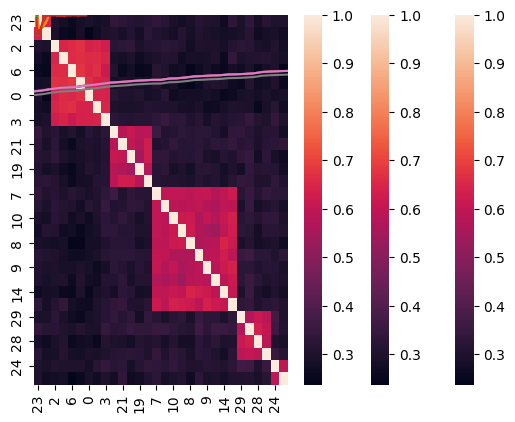

In [1]:
import numpy as np
import pandas as pd

from scipy.linalg import block_diag
from sklearn.utils import check_random_state

import matplotlib.pyplot as plt
import seaborn as sns

import import_ipynb
from ch2 import formBlockMatrix, cov2corr, formTrueMatrix, simCovMu, deNoiseCov, optPort
from ch4 import clusterKMeansBase

measurement and source of convariance instability caused by structure of the data (signal)

3.0


<Axes: >

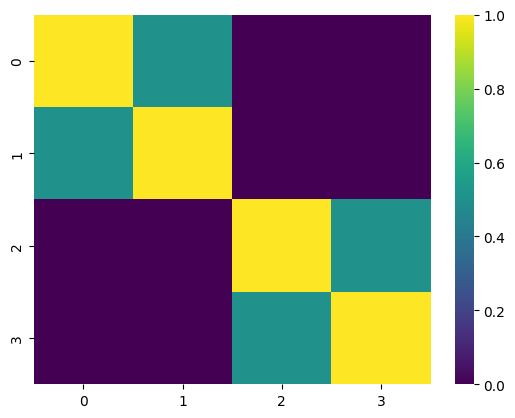

In [ ]:
# signal (structure of the data) is the cause of this type of covariance instability, not noise. 
#   different with section 2, for which instability grows with N_nFacts/T_nObs ratio.
#   singal-induced instability is structual, and cannot be reduced by sampling more observations.


# example

# original
corr0 = formBlockMatrix(2, 2, 0.5)
#[[1.  0.5 0.  0. ]
# [0.5 1.  0.  0. ]
# [0.  0.  1.  0.5]
# [0.  0.  0.5 1. ]]

eVal, eVec = np.linalg.eigh(corr0)
# condition number
# the bigger one eigenvalue becomes relative to the other (i.e. the greater the condition number)
#   the more |C| approaches zero (=>inv(C) or inv(V) to explode, for which w* depends on) 
#   the more unstable for optimization
print (max(eVal) / min(eVal))

# visualization                                
sns.heatmap(corr0, cmap='viridis')

4.000000000000002


<Axes: >

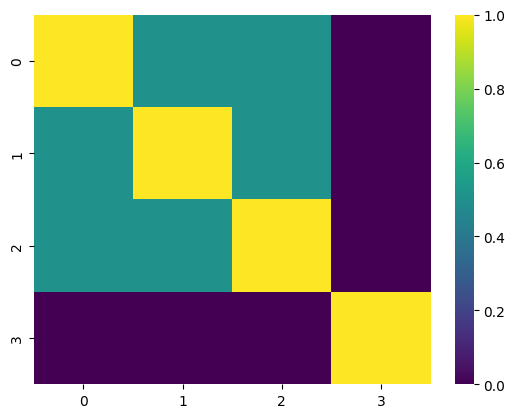

In [ ]:
# the condition number rises if

# 1) make one block greater/bigger 
corr0 = block_diag(formBlockMatrix(1, 3, 0.5),formBlockMatrix(1, 1, 0.5))
eVal, eVec = np.linalg.eigh(corr0)
print (max(eVal) / min(eVal))                  
sns.heatmap(corr0, cmap='viridis')

7.0


<Axes: >

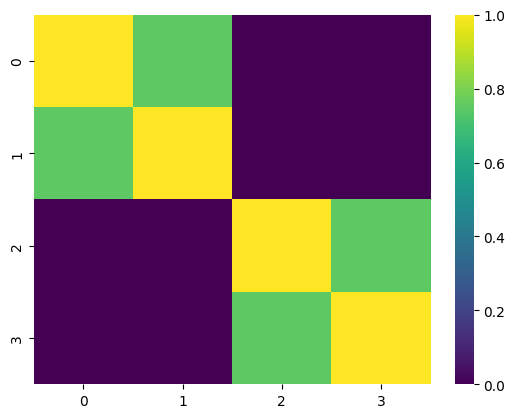

In [ ]:
# 2) increase the intrablock correlation
# the greater the intracluster correlation, the greater the condition number
corr0 = formBlockMatrix(2, 2, 0.75)
eVal, eVec = np.linalg.eigh(corr0)
print (max(eVal) / min(eVal))                  
sns.heatmap(corr0, cmap='viridis')

3.0


<Axes: >

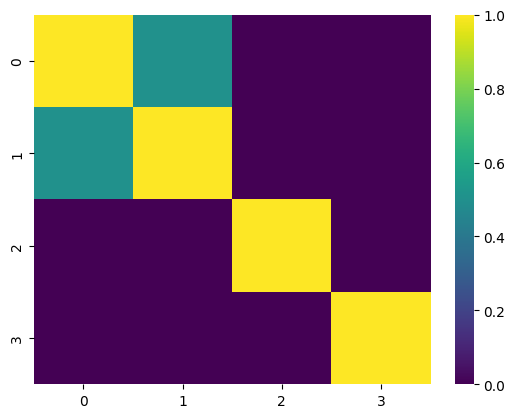

In [5]:
# bring down the intrablock correlation in only one of the two blocks 
#   does not reduce the condition number given the extreme eigen values are caused by dominant block
corr0 = block_diag(formBlockMatrix(1, 2, 0.5),formBlockMatrix(1, 2, 0.0))
eVal, eVec = np.linalg.eigh(corr0)
print (max(eVal) / min(eVal))      # condition number is still 3.0             
sns.heatmap(corr0, cmap='viridis')

# Implication: the instability of markowitz's solution can be traced back to a few dominant clusters
#               we can contain the instability by optimizing the dominant clusters separately

nested clustered optimization(NCO) algorithm

In [ ]:
# step 1: the correlation clustering step

##corr0 = cov2corr(cov0)

# denoise cov (for large matrices, where T_nObs/N_nFacts is relatively low) q = T/N
##cov1 = deNoiseCov(cov0, q=25, bWidth=0.01)

# standardize the matrix
##corr1 = cov2corr(cov1)

# cluster the cleaned corr matrix
# maxNumClusters = half of the columns in corr0 
#   given single-item cluster will not increase condition number, so we only need to consider clusters with a minimum size of two
##corr1, clstrs, silh = clusterKMeansBase(corr1, maxNumClusters=corr0.shape[0]/2, n_init=10)



# step 2: compute optimal intracluster allocations using denoised cov matrix (cov1)

##wIntra = pd.DataFrame(0, index=cov1.index, columns=clstrs.keys())
##for i in clstrs:
##    wIntra.loc[clstrs[i], i] = optPort(cov1.loc[clstrs[i], clstrs[i]], None).flatten()
##cov2 = wIntra.T.dot(np.dot(cov1, wIntra)) # reduced cov matrix



# step 3: compute optimal intercluster allocations using the reduced cov (cov2)
#   by construction, the cov matrix is close to diagonal matrx, optimization is close to the deal Markowitz case

##wInter = pd.Series(optPort(cov2, None).flatten(), index=cov2.index)

# final allocation per security (multiply intracluster weights with the intercluster weights)
##wAll0 = wIntra.mul(wInter, axis=1).sum(axis=1).sort_index()

In [7]:
def optPort_nco(cov, mu=None, maxNumClusters=None): # minVarPortf if mu=None, maxSRPortf if mu is not None
    
    cov = pd.DataFrame(cov)
    if mu is not None:
        mu = pd.Series(mu[:,0]) # first column
    
    corr1 = cov2corr(cov)
    # step 1: correlation clustering
    corr1, clstrs, _ = clusterKMeansBase(corr1, maxNumClusters, n_init=10)
    
    # step 2: compute intracorrelation allocations
    wIntra = pd.DataFrame(0, index=cov.index, columns=clstrs.keys())
    for i in clstrs:
        cov_ = cov.loc[clstrs[i], clstrs[i]].values
        if mu is None:
            mu_ = None
        else:
            mu_ = mu.loc[clstrs[i]].values.reshape(-1, 1)
        wIntra.loc[clstrs[i], i] = optPort(cov_, mu_).flatten()
    
    cov_ = wIntra.T.dot(np.dot(cov, wIntra))  # reduced covariance matrix
    mu_ = (None if mu is None else wIntra.T.dot(mu))

    # step 3: compute intercorrelation allocations
    wInter = pd.Series(optPort(cov_, mu_).flatten(), index=cov_.index)
    
    # return all allocations per security
    nco = wIntra.mul(wInter, axis=1).sum(axis=1).values.reshape(-1, 1)

    return nco

NCO vs. Markowitz - minimum variance portfolio

In [ ]:

# create true cov0 (data generation process)
nBlocks, bSize, bCorr = 10, 50, .5  # 10 blocks, 50 securities, intracluster correlation of 0.5 
np.random.seed(0)
mu0, cov0 = formTrueMatrix(nBlocks, bSize, bCorr)


# empirical mu and cov (based on DGP)
# shrink = False
nObs, nSims, shrink, minVarPortf = 1000, 10, False, True     # only 10 trials due to hardware contraints
w1 = pd.DataFrame(columns=range(cov0.shape[0]), index=range(nSims), dtype=float)
w1_d = w1.copy(deep=True)
np.random.seed(0)
for i in range(nSims):
    mu1, cov1 = simCovMu(mu0, cov0, nObs, shrink=shrink)
    if minVarPortf: mu=None
    w1.loc[i] = optPort(cov1, mu1).flatten() # Markowitz approach
    w1_d.loc[i] = optPort_nco(cov1, mu1, int(cov1.shape[0]/2)).flatten() # nco approach


# estimation of allocation errors
w0 = optPort(cov0, None if minVarPortf else mu0)
w0 = np.repeat(w0.T, w1.shape[0], axis=0)   # true allocation (based on true cov0)
rmsd = np.mean((w1 - w0).values.flatten()**2)**.5   # RMSE (markowitz vs true)
rmsd_d = np.mean((w1_d -w0).values.flatten()**2)**.5   # RMSE (nco vs true)
print(rmsd, rmsd_d)

<string>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
<string>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
<string>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
<string>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
<string>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
<string>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtyp

0.10233598638201333 0.06476817965199545


In [10]:
# shrink = True
nObs, nSims, shrink, minVarPortf = 1000, 10, True, True     # only 10 trials due to hardware contraints
w1 = pd.DataFrame(columns=range(cov0.shape[0]), index=range(nSims), dtype=float)
w1_d = w1.copy(deep=True)
np.random.seed(0)
for i in range(nSims):
    mu1, cov1 = simCovMu(mu0, cov0, nObs, shrink=shrink)
    if minVarPortf: mu=None
    w1.loc[i] = optPort(cov1, mu1).flatten() # Markowitz approach
    w1_d.loc[i] = optPort_nco(cov1, mu1, int(cov1.shape[0]/2)).flatten() # nco approach


# estimation of allocation errors
w0 = optPort(cov0, None if minVarPortf else mu0)
w0 = np.repeat(w0.T, w1.shape[0], axis=0)   # true allocation (based on true cov0)
rmsd = np.mean((w1 - w0).values.flatten()**2)**.5   # RMSE (markowitz vs true)
rmsd_d = np.mean((w1_d -w0).values.flatten()**2)**.5   # RMSE (nco vs true)
print(rmsd, rmsd_d)

<string>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
<string>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
<string>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
<string>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
<string>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
<string>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtyp

0.21893205769408358 0.05755864096679439


In [ ]:
# based on above results

#          markowitz     nco
# raw      0.1023        0.0647
# shrunk   0.2189        0.0576     

# implication: NCO delivers substantially lower RMSE than Markowitz's solution, while shrinkage adds no value.
#              similar for maximum sharpe ratio portfolio (minVarPortf = False)


# NCO splits the optimization problem into several problems, computing one optimization per cluster
#           and computing one final optimization across all clusters. Experiemental results show the dual clustering approach reduce the Markowtiz's estimation error.


# NCO is flexible and modular. 
# when correlation matrix exhibits strongly hierarchical structure, with clusters within clusters, 
#   can apply the nco algo within each cluster and subcluster, mimick the tree-like sturcture.
# the goal is to contain the numerical instability at each level of the tree, 
#   so that the instability within a subcluster does not extend to its parent cluster or the rest of corr matrix 